In [38]:
import math
import numpy as np
from numpy import *
from numpy import linalg as la
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import os
import difflib
from scipy.sparse import csr_matrix
import pandas as pd
dir_data = os.path.realpath('../data')
dir_results = os.path.realpath('../result')

In [49]:
import findspark
findspark.init('/home/zm2303/spark')
import pyspark

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType

In [51]:
# build a spark session
spark = SparkSession\
    .builder\
    .appName("SVD")\
    .getOrCreate()

# SVD function

In [61]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry

In [260]:
def load_data():
    data_train = spark.read.csv(dir_data + '/' +'1M_train_top80.csv', header = True, inferSchema = True, sep = ',')
    data_test = spark.read.csv(dir_data + '/' +'1M_train_top80.csv', header = True, inferSchema = True, sep = ',')
    simple_test = data_test.select(['user_id','item_id','target'])
    simple_train = data_train.select(['user_id','item_id','target'])
    return data_train, data_test, simple_train, simple_test

In [263]:
def mat_data( simple_train, simple_test ):
    mat_train = CoordinateMatrix(simple_train.rdd.map(lambda row: MatrixEntry(*row)))
    mat_train = mat_train.toRowMatrix()
    mat_test = CoordinateMatrix(simple_test.rdd.map(lambda row: MatrixEntry(*row)))
    mat_test = mat_test.toRowMatrix()
    return mat_train, mat_test

In [108]:
def SVD(mat, k):
    svd = mat.computeSVD(k, computeU=True)
    vec_U = svd.U.rows.collect()
    vec_U = np.stack( vec_U, axis=0 )
    
    vec_S = np.zeros((k,k))
    diag_S = svd.s.toArray()
    for i in range(k):
        vec_S[i,i] = diag_S[i]

    vec_V = svd.V.toArray()
    return vec_U, vec_S, np.transpose(vec_V)

In [253]:
def get_rmse(U,S,Vt):
    right_term = np.mat(S)*np.mat(Vt)
    square_error_sum = 0
    num_test = 0
    for i in range(U.shape[0]):
        user_feature = np.matrix(U[i,:])
        rating = np.array(user_feature * right_term)
        idx_item = np.where(test_array[:,0] == i)[0]

        item_in_test = test_array[idx_item,1]
        target_in_test = test_array[idx_item,2]

        pred = rating[0,item_in_test]
        num_test += pred.shape[0]
        square_error_sum += ((target_in_test - pred)**2).sum()
    rmse = math.sqrt(square_error_sum/ num_test)
    return rmse

In [262]:
data_train, date_test, simple_train, simple_test = load_data()

In [264]:
mat_train, mat_test = mat_data(simple_train, simple_test)

In [265]:
U, S, Vt = SVD(mat_train,5)

In [254]:
RMSE = []
for k in range(5,51,5):
    U, S, Vt = SVD(mat_train,k)
    rmse = get_rmse(U,S,Vt)
    RMSE.append(rmse)
    print("k= {}  rmse = {}".format(k, rmse))

k= 5  rmse = 0.8003207198290588
k= 10  rmse = 0.8007292722946386
k= 15  rmse = 0.8011834279922992
k= 20  rmse = 0.8015893758778195
k= 25  rmse = 0.8018737112720412
k= 30  rmse = 0.8021572037836594
k= 35  rmse = 0.8024503031696952
k= 40  rmse = 0.8026062891625323
k= 45  rmse = 0.8027885032361883
k= 50  rmse = 0.8029322501410318


In [255]:
RMSE

[0.8003207198290588,
 0.8007292722946386,
 0.8011834279922992,
 0.8015893758778195,
 0.8018737112720412,
 0.8021572037836594,
 0.8024503031696952,
 0.8026062891625323,
 0.8027885032361883,
 0.8029322501410318]

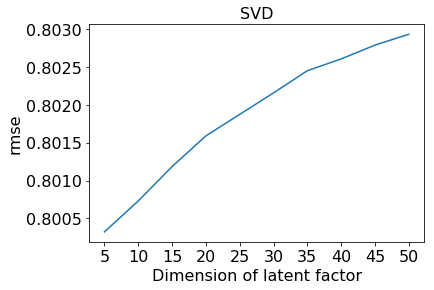

In [257]:
plt.plot(list(x for x in range(5,51,5)),RMSE)
plt.xticks(list(x for x in range(5,51,5)), fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("SVD", fontsize = 16)
plt.xlabel("Dimension of latent factor", fontsize = 16)
plt.ylabel("rmse", fontsize = 16)
plt.savefig("SVD.png", bbox_inches = "tight", dpi = 300)